In [1]:
warnings('off')

library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
library(stringr)
set.seed(1234)

setwd('/Users/gaozj/Documents/scATAC/')

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:Signac’:

    FoldChange


Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.0.5”
Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.0.5”
Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, 

# Pre-processing workflow

In [2]:
counts <- Read10X_h5(filename = "atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file = "atac_v1_pbmc_10k_singlecell.csv",
  header = TRUE,
  row.names = 1
)

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'hg19',
  fragments = 'atac_v1_pbmc_10k_fragments.tsv.gz',
  min.cells = 10,
  min.features = 200
)

pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

pbmc

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead

Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


An object of class Seurat 
87561 features across 8728 samples within 1 assay 
Active assay: peaks (87561 features, 0 variable features)

In [3]:
chrom_assay

ChromatinAssay data with 87561 features for 8728 cells
Variable features: 0 
Genome: hg19 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

GRanges object with 87561 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     565107-565550      *
      [2]     chr1     569174-569639      *
      [3]     chr1     713460-714823      *
      [4]     chr1     752422-753038      *
      [5]     chr1     762106-763359      *
      ...      ...               ...    ...
  [87557]     chrY 58993392-58993760      *
  [87558]     chrY 58994571-58994823      *
  [87559]     chrY 58996352-58997331      *
  [87560]     chrY 59001782-59002175      *
  [87561]     chrY 59017143-59017246      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

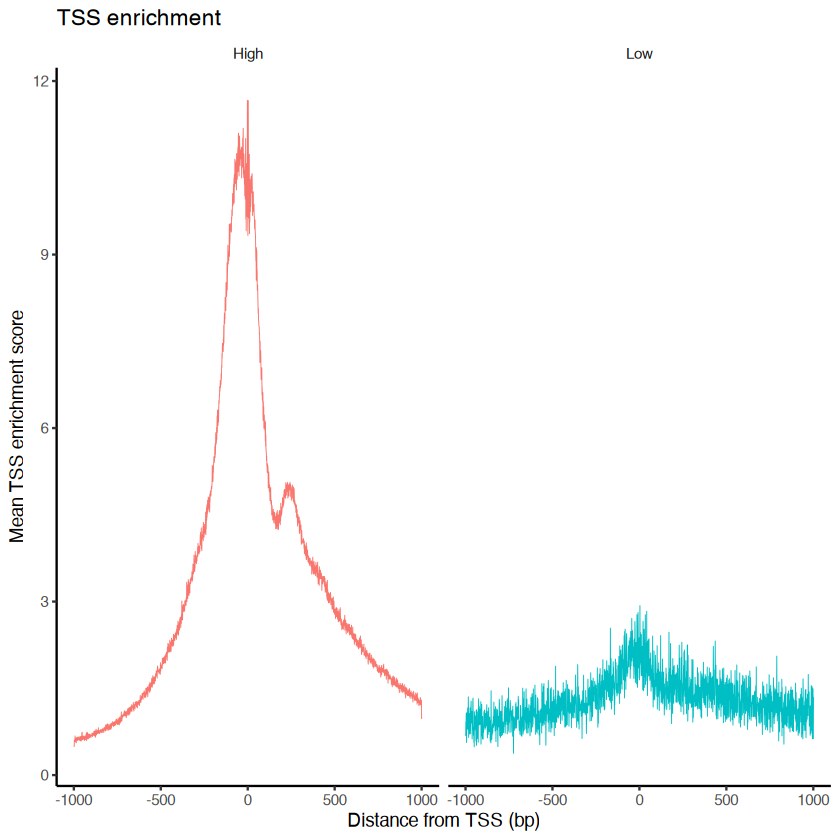

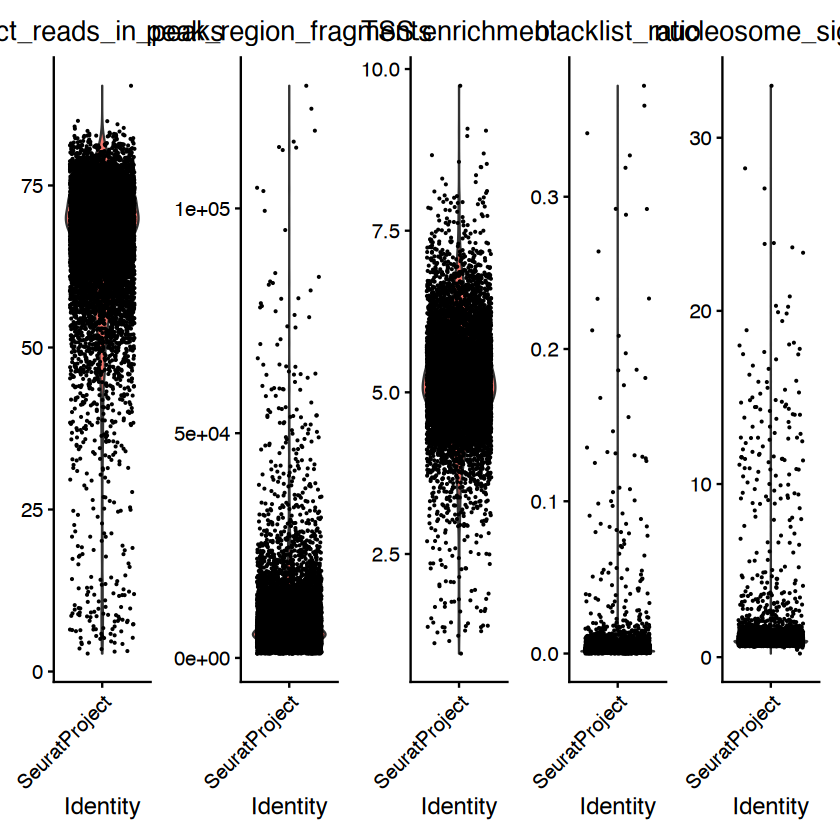

In [4]:
granges(pbmc)


# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# change to UCSC style since the data was mapped to hg19
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg19"

# add the gene information to the object
Annotation(pbmc) <- annotations


# compute nucleosome signal score per cell
pbmc <- NucleosomeSignal(object = pbmc)

# compute TSS enrichment score per cell
pbmc <- TSSEnrichment(object = pbmc, fast = FALSE)

# add blacklist ratio and fraction of reads in peaks
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100
pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments

pbmc$high.tss <- ifelse(pbmc$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(pbmc, group.by = 'high.tss') + NoLegend()

pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 4, 'NS > 4', 'NS < 4')


VlnPlot(
  object = pbmc,
  features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)


In [5]:
pbmc <- subset(
  x = pbmc,
  subset = peak_region_fragments > 3000 &
    peak_region_fragments < 20000 &
    pct_reads_in_peaks > 15 &
    blacklist_ratio < 0.05 &
    nucleosome_signal < 4 &
    TSS.enrichment > 2
)
pbmc

An object of class Seurat 
87561 features across 7060 samples within 1 assay 
Active assay: peaks (87561 features, 0 variable features)

# Normalization and linear dimensional reduction

In [6]:
pbmc <- RunTFIDF(pbmc)
pbmc <- FindTopFeatures(pbmc, min.cutoff = 'q0')
pbmc <- RunSVD(pbmc)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"字符0x9不带字体宽度这样的设置"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"字符0x9不带字体宽度这样的设置"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"字符0x9不带字体宽度这样的设置"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"字符0x9不带字体宽度这样的设置"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"字符0x9不带字体宽度这样的设置"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"字符0x9不带字体宽度这样的设置"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"字符0x9不带字体宽度这样的设置"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"字符0x9不带字体宽度这样的设置"


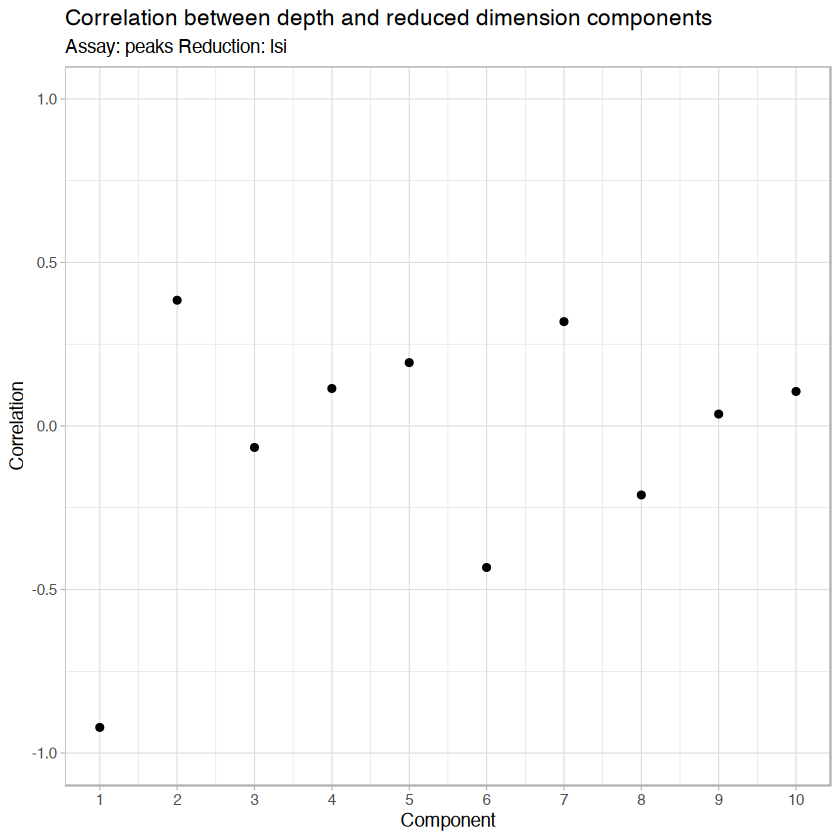

In [7]:
DepthCor(pbmc)

In [8]:
pbmc_ref <- pbmc

# Non-linear dimension reduction and clustering


In [9]:
pbmc <- RunUMAP(object = pbmc, reduction = 'lsi', dims = 1:30)
pbmc <- FindNeighbors(object = pbmc, reduction = 'lsi', dims = 1:30)
pbmc <- FindClusters(object = pbmc, verbose = FALSE, algorithm = 3)
plot <- DimPlot(object = pbmc, label = TRUE) + NoLegend()
ggsave(plot, filename = "plot_origin.png", width = 8, height = 6,dpi = 450)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
13:56:00 UMAP embedding parameters a = 0.9922 b = 1.112

13:56:00 Read 7060 rows and found 30 numeric columns

13:56:00 Using Annoy for neighbor search, n_neighbors = 30

13:56:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:56:00 Writing NN index file to temp file /var/folders/99/vgtbqjkd7rs8m03kzbjw_rfm0000gn/T//RtmpxoIGHV/file5851e695f86

13:56:00 Searching Annoy index using 1 thread, search_k = 3000

13:56:01 Annoy recall = 100%

13:56:03 Commencing smooth kNN distance calibrati

# Reference method (refProj)

In [11]:
# obtain the count matrix
cnt <- GetAssayData(pbmc,slot = 'counts')
peaks <- str_split(rownames(cnt),'-',simplify = TRUE)
padding <- rep(c('.','.','.'),dim(peaks)[1])
padding <- matrix(padding,nrow=dim(peaks)[1],byrow=TRUE)
bedcontent <- cbind(peaks,padding)
write.table(bedcontent, "Signac.bed",col.names = FALSE,quote =FALSE,row.names = FALSE,eol = '\n',sep = '\t')

In [ ]:
library(OpenAnnotateR)
input <- "Signac.bed"
taskid <- runAnnotate(input, 1, 1, 1)
getProgress(taskid)

In [ ]:
getAnnoResult(3,1,taskid)

In [ ]:
getAnnoResult(2,1,taskid)

In [11]:
peakopen <- read.table('./results/2022091520215640_peakopen.txt.gz',header = FALSE,row.names = rownames(cnt))
peakopen <- peakopen[,5:dim(peakopen)[2]]
peakopen.pca <- prcomp(t(peakopen),rank=50)


readopen <- read.table('./results/2022091520215640_readopen.txt.gz',header = FALSE)
readopen <- readopen[,5:dim(readopen)[2]]
readopen.pca <- prcomp(t(readopen),rank=50)

In [12]:
# Perform TF-IDF (count_mat: peak*cell)
tfidf1=function(count_mat){
    nfreqs <- 1.0 * count_mat / (1e-5+matrix(rep(colSums(count_mat),dim(count_mat)[1]),byrow = T,nrow=dim(count_mat)[1]))
    tfidf_mat <- nfreqs * matrix(rep(log(1 + 1.0 * dim(count_mat)[2] / (1e-5+rowSums(count_mat))),dim(count_mat)[2]),byrow = F,ncol=dim(count_mat)[2])
    return(tfidf_mat)
}
tfidf2 <- function(count_mat) {
  tf_mat <- 1.0 * count_mat / matrix(rep(rowSums(count_mat), each = ncol(count_mat)), nrow = nrow(count_mat), byrow = TRUE)
  signac_mat <- log(1 + 10000 * tf_mat * matrix((1.0 * ncol(count_mat) / rowSums(count_mat)), nrow = nrow(count_mat), ncol = ncol(count_mat)))
  return(as.matrix(signac_mat))
}

# Perform TF-IDF using 'tm' package
library(tm)
tfidf3 <- function(count_mat) {
  t_count_mat <- t(count_mat)
  dtm <- DocumentTermMatrix(DataFrame(t_count_mat))
  tfidf_mat <- weightTfIdf(dtm, normalize = FALSE)
  return(as.matrix(as.matrix(tfidf_mat)))
}

Loading required package: NLP


Attaching package: 'NLP'


The following object is masked from 'package:ggplot2':

    annotate


The following object is masked from 'package:GenomicFeatures':

    features


The following objects are masked from 'package:Biobase':

    annotation, content


The following object is masked from 'package:BiocGenerics':

    annotation


The following object is masked from 'package:Signac':

    Annotation




In [99]:
norm.embeddings_read <- t(cnt) %*% readopen.pca$rotation
norm.embeddings_peak <- t(cnt) %*% peakopen.pca$rotation

In [146]:
tmp.norm.embeddings <- cbind(scale(pbmc[['lsi']]@cell.embeddings[,1:30]),scale(norm.embeddings_read[,1:5]),scale(norm.embeddings_peak[,1:5]))

norm.embeddings <- matrix(tmp.norm.embeddings,nrow = dim(norm.embeddings_read)[1],dimnames = list(row.names(norm.embeddings_read),colnames(norm.embeddings_read)[1:40]))

In [147]:
# create the dimentionality reduction result with refProj
reduction.data <- CreateDimReducObject(
  embeddings = as.matrix(norm.embeddings),
  loadings = readopen.pca$rotation[,1:40],
  stdev = readopen.pca$sdev,
  assay = 'peaks',
  key = 'pcacombineopen_',
)

In [148]:
pbmc_ref[['pca_combineopen']] <- reduction.data

In [149]:
pbmc_ref <- RunUMAP(object = pbmc_ref, reduction = 'pca_combineopen', dims = 1:40)
pbmc_ref <- FindNeighbors(object = pbmc_ref, reduction = 'pca_combineopen', dims = 1:40)
pbmc_ref <- FindClusters(object = pbmc_ref, verbose = FALSE, algorithm = 3)
plot <- DimPlot(object = pbmc_ref, label = TRUE) + NoLegend()
ggsave(plot, filename = "plot_ref_read.png", width = 8, height = 6,dpi = 450)

14:58:11 UMAP embedding parameters a = 0.9922 b = 1.112

14:58:11 Read 7060 rows and found 40 numeric columns

14:58:11 Using Annoy for neighbor search, n_neighbors = 30

14:58:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:58:12 Writing NN index file to temp file /var/folders/99/vgtbqjkd7rs8m03kzbjw_rfm0000gn/T//RtmpxoIGHV/file58524f6bba8

14:58:12 Searching Annoy index using 1 thread, search_k = 3000

14:58:13 Annoy recall = 100%

14:58:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:58:16 Initializing from normalized Laplacian + noise (using irlba)

14:58:16 Commencing optimization for 500 epochs, with 286428 positive edges

14:58:25 Optimization finished

Computing nearest neighbor graph

Computing SNN



In [150]:
# clustering performance of refProj method
library(cluster)
library(fpc)
stats <- cluster.stats(dist(pbmc_ref@reductions$umap@cell.embeddings), as.numeric(pbmc_ref$seurat_clusters))
print(c(stats$avg.silwidth,stats$ch))

[1] 4.087087e-01 2.468679e+04


In [88]:
# clustering performance of Signac
stats <- cluster.stats(dist(pbmc@reductions$umap@cell.embeddings), as.numeric(pbmc$seurat_clusters))
print(c(stats$avg.silwidth,stats$ch))

[1]    0.3994674 9934.6273824


# Create a gene activity matrix

In [151]:
gene.activities <- GeneActivity(pbmc)
gene.activities_ref <- GeneActivity(pbmc_ref)

Extracting gene coordinates

Extracting reads overlapping genomic regions

Extracting gene coordinates

Extracting reads overlapping genomic regions



In [152]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
pbmc[['RNA']] <- CreateAssayObject(counts = gene.activities)
pbmc <- NormalizeData(
  object = pbmc,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(pbmc$nCount_RNA)
)

# add the gene activity matrix to the Seurat object as a new assay and normalize it
pbmc_ref[['RNA']] <- CreateAssayObject(counts = gene.activities_ref)
pbmc_ref <- NormalizeData(
  object = pbmc_ref,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(pbmc_ref$nCount_RNA)
)

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"
Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"


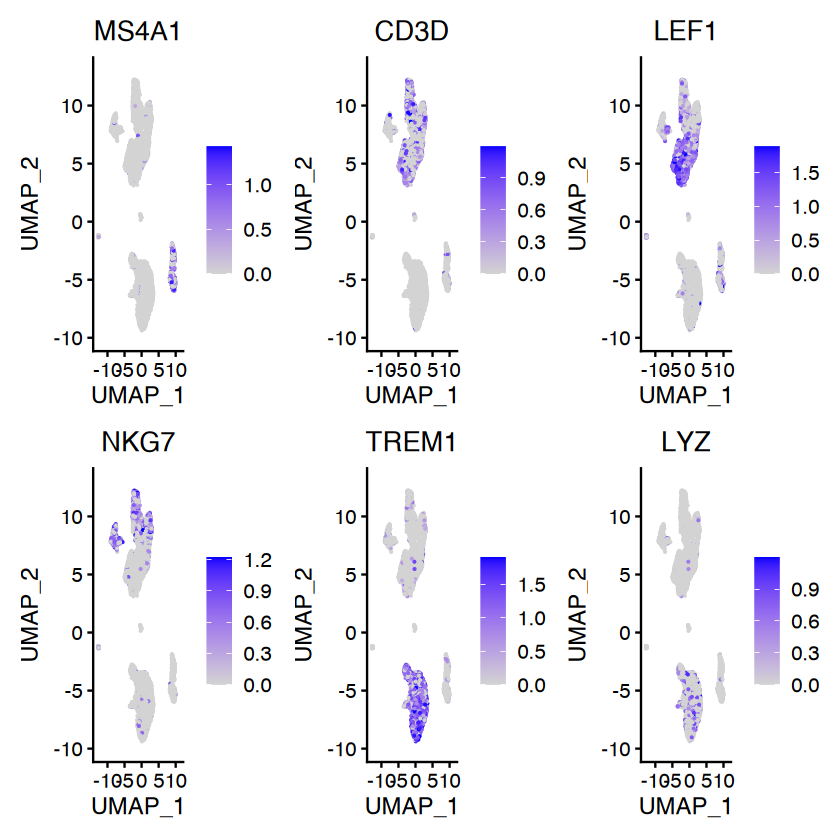

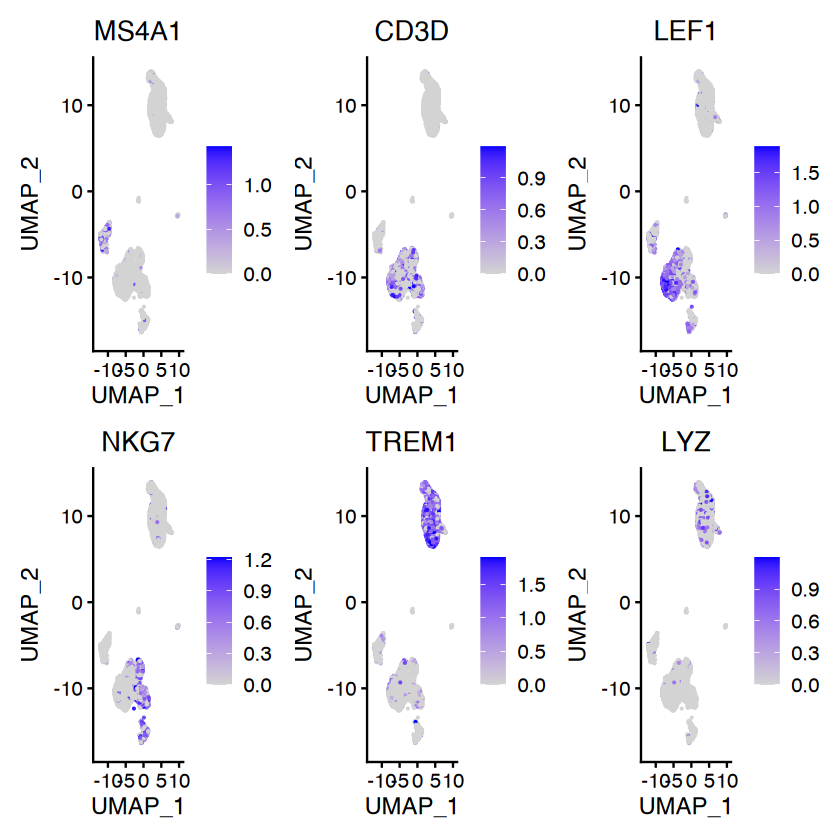

In [153]:
DefaultAssay(pbmc) <- 'RNA'

FeaturePlot(
  object = pbmc,
  features = c('MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

DefaultAssay(pbmc_ref) <- 'RNA'

FeaturePlot(
  object = pbmc_ref,
  features = c('MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

# Integrating with scRNA-seq data

In [154]:
# Load the pre-processed scRNA-seq data for PBMCs
pbmc_rna <- readRDS("./pbmc_10k_v3.rds")
pbmc_rna_ref <- readRDS("./pbmc_10k_v3.rds")

# origin
transfer.anchors <- FindTransferAnchors(
  reference = pbmc_rna,
  query = pbmc,
  reduction = 'cca'
)

predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = pbmc_rna$celltype,
  weight.reduction = pbmc[['lsi']],
  dims = 1:30
)

pbmc <- AddMetaData(object = pbmc, metadata = predicted.labels)

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17306 anchors

Filtering anchors

	Retained 4019 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [155]:
dim(norm.embeddings)

[1] 7060   40

In [158]:
# reference
transfer.anchors_ref <- FindTransferAnchors(
  reference = pbmc_rna_ref,
  query = pbmc_ref,
  reduction = 'cca'
)

predicted.labels_ref <- TransferData(
  anchorset = transfer.anchors_ref,
  refdata = pbmc_rna_ref$celltype,
  weight.reduction = pbmc_ref[['pca_combineopen']],
  dims = 1:40
)
pbmc_ref <- AddMetaData(object = pbmc_ref, metadata = predicted.labels_ref)

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17306 anchors

Filtering anchors

	Retained 4019 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



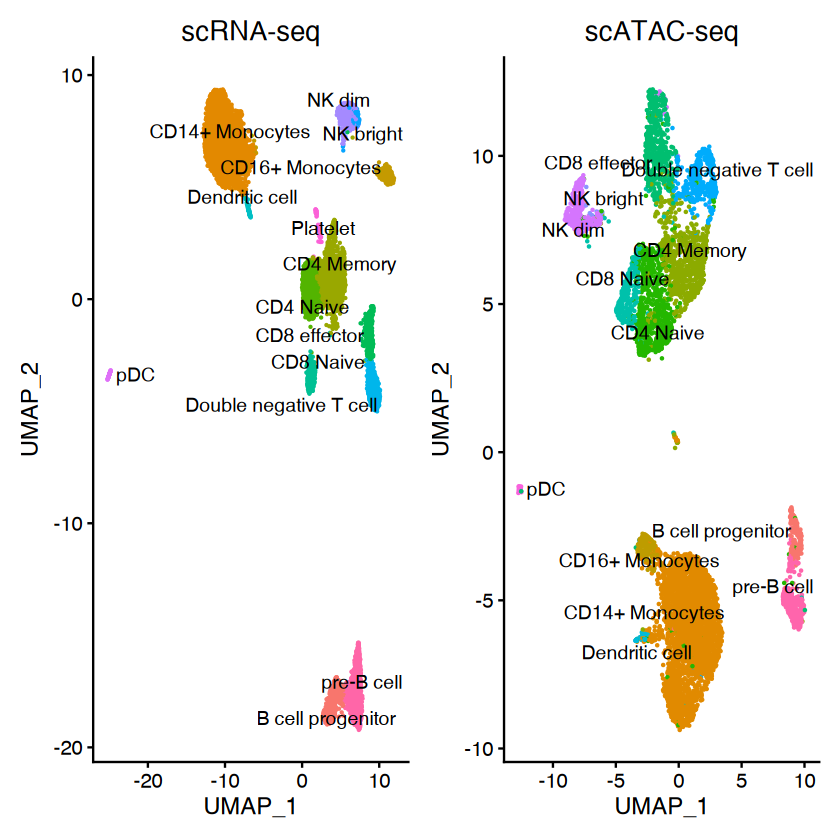

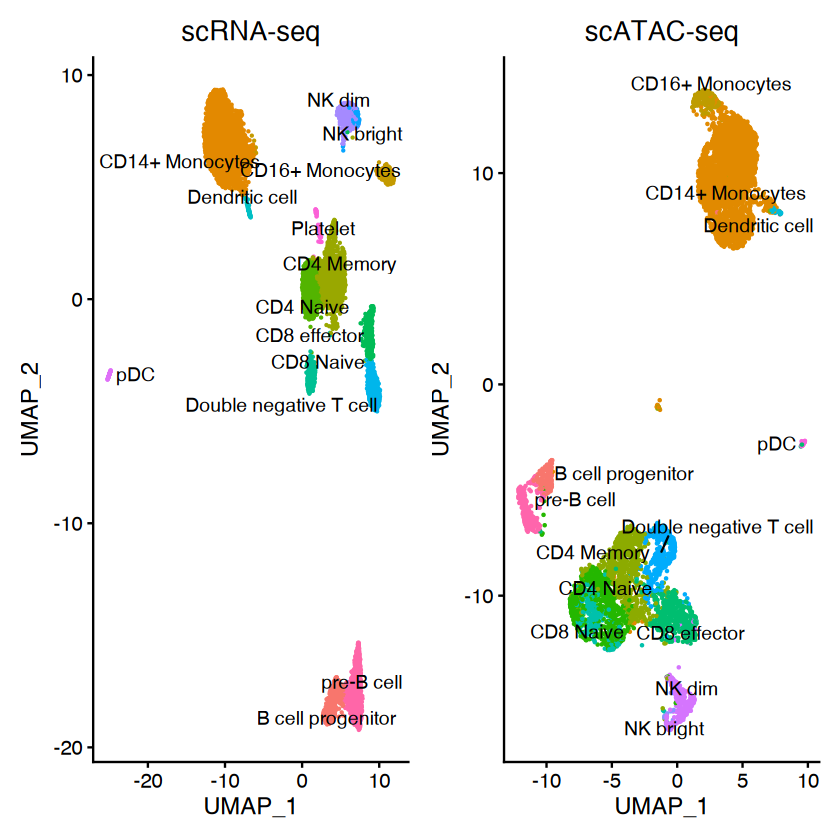

In [159]:
plot1 <- DimPlot(
  object = pbmc_rna,
  group.by = 'celltype',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scRNA-seq')

plot2 <- DimPlot(
  object = pbmc,
  group.by = 'predicted.id',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scATAC-seq')

plot1 + plot2
plot3 <- DimPlot(
  object = pbmc_rna_ref,
  group.by = 'celltype',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scRNA-seq')

plot4 <- DimPlot(
  object = pbmc_ref,
  group.by = 'predicted.id',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scATAC-seq')

plot3 + plot4

In [160]:
ggsave(plot1, filename = "plot_origin_inte_rna.png", width = 8, height = 6,dpi = 450)
ggsave(plot2, filename = "plot_origin_inte_atac.png", width = 8, height = 6,dpi = 450)
ggsave(plot3, filename = "plot_read_inte_rna.png", width = 8, height = 6,dpi = 450)
ggsave(plot4, filename = "plot_read_inte_atac.png", width = 8, height = 6,dpi = 450)

In [161]:
pbmc_ref <- subset(pbmc_ref, idents = 14, invert = TRUE)
pbmc_ref <- RenameIdents(
  object = pbmc_ref,
  '0' = 'CD14 Mono',
  '1' = 'CD4 Memory',
  '2' = 'CD8 Effector',
  '3' = 'CD4 Naive',
  '4' = 'CD14 Mono',
  '5' = 'DN T',
  '6' = 'CD8 Naive',
  '7' = 'NK CD56Dim',
  '8' = 'pre-B',
  '9' = 'CD16 Mono',
  '10' = 'pro-B',
  '11' = 'DC',
  '12' = 'NK CD56bright',
  '13' = 'pDC'
)

pbmc <- subset(pbmc, idents = 14, invert = TRUE)
pbmc <- RenameIdents(
  object = pbmc,
  '0' = 'CD14 Mono',
  '1' = 'CD4 Memory',
  '2' = 'CD8 Effector',
  '3' = 'CD4 Naive',
  '4' = 'CD14 Mono',
  '5' = 'DN T',
  '6' = 'CD8 Naive',
  '7' = 'NK CD56Dim',
  '8' = 'pre-B',
  '9' = 'CD16 Mono',
  '10' = 'pro-B',
  '11' = 'DC',
  '12' = 'NK CD56bright',
  '13' = 'pDC'
)

# Find differentially accessible peaks between clusters

In [162]:
# change back to working with peaks instead of gene activities
DefaultAssay(pbmc_ref) <- 'peaks'

da_peaks_ref <- FindMarkers(
  object = pbmc_ref,
  ident.1 = "CD4 Naive",
  ident.2 = "CD14 Mono",
  test.use = 'LR',
  latent.vars = 'peak_region_fragments'
)

head(da_peaks_ref)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr2-87012330-87019208,1.914559e-162,1.505012,0.705,0.041,1.676407e-157
chr12-52960193-52961359,6.002795e-105,1.971486,0.400,0.002,5.256107e-100
chr20-24929211-24935052,2.572124e-103,1.295656,0.674,0.085,2.252177e-98
chr20-24940158-24942440,8.616118e-102,1.721350,0.477,0.013,7.544359e-97
chr1-25390920-25393219,3.041889e-100,1.664997,0.480,0.019,2.663508e-95
chr2-232290043-232292221,8.448125e-89,1.516547,0.519,0.034,7.397263e-84


In [163]:
# change back to working with peaks instead of gene activities
DefaultAssay(pbmc) <- 'peaks'

da_peaks <- FindMarkers(
  object = pbmc,
  ident.1 = "CD4 Naive",
  ident.2 = "CD14 Mono",
  test.use = 'LR',
  latent.vars = 'peak_region_fragments'
)

head(da_peaks)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr14-99721608-99741934,6.154962e-300,1.129644,0.876,0.023,5.389346e-295
chr17-80084198-80086094,2.160495e-240,1.630683,0.706,0.006,1.891751e-235
chr14-99695477-99720910,5.269072e-240,1.134736,0.825,0.022,4.613653e-235
chr7-142501666-142511108,7.071969e-236,1.003513,0.774,0.030,6.192287e-231
chr6-44025105-44028184,2.200469e-207,-1.247392,0.066,0.655,1.926753e-202
chr2-113581628-113594911,2.624173e-204,-1.267048,0.065,0.693,2.297752e-199


In [164]:
rownames(da_peaks)[1]

[1] "chr14-99721608-99741934"

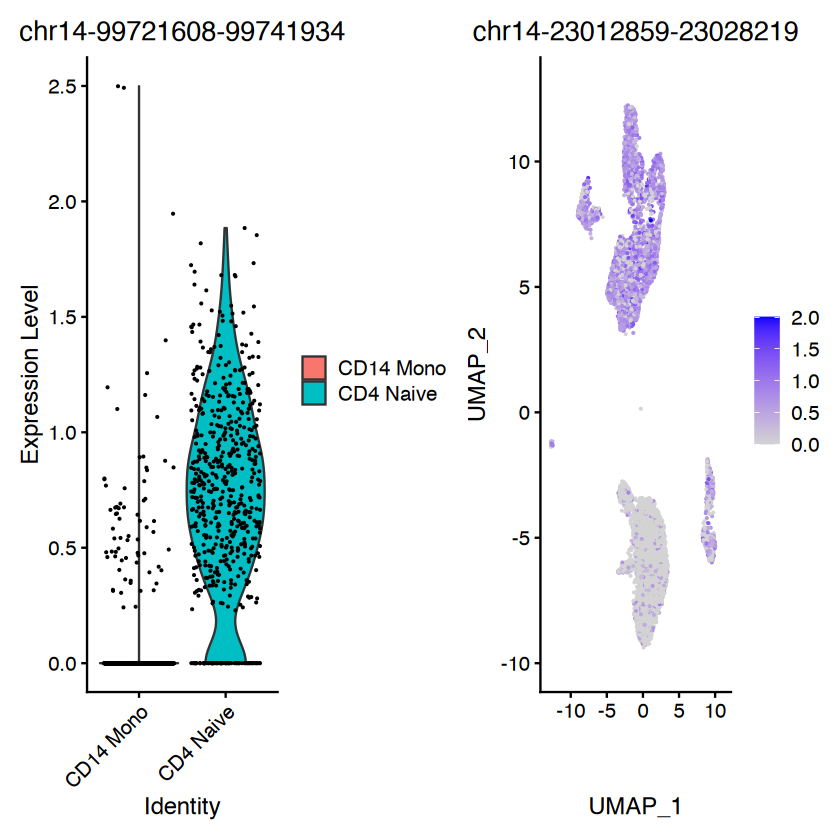

In [171]:
plot1 <- VlnPlot(
  object = pbmc,
  features = rownames(da_peaks)[1],
  pt.size = 0.1,
  idents = c("CD4 Naive","CD14 Mono")
)
plot2 <- FeaturePlot(
  object = pbmc,
  features = rownames(da_peaks)[7],
  pt.size = 0.1
)

plot1 | plot2

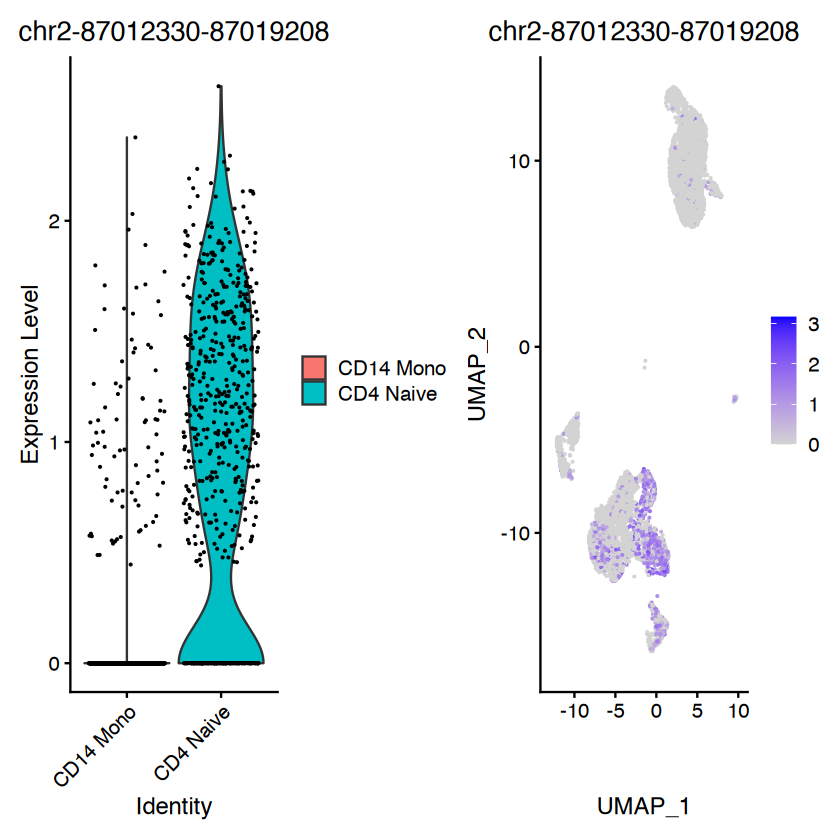

In [170]:
plot3 <- VlnPlot(
  object = pbmc_ref,
  features = rownames(da_peaks_ref)[1],
  pt.size = 0.1,
  idents = c("CD4 Naive","CD14 Mono")
)
plot4 <- FeaturePlot(
  object = pbmc_ref,
  features = rownames(da_peaks_ref)[1],
  pt.size = 0.1
)

plot3 | plot4